In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.float_format', '{:,.2f}'.format)

In [ ]:
# read datasets
df_start_may21 = pd.read_csv('01.05.2021.csv')
df_end_may21 = pd.read_csv('21.05.2021.csv')
df_may20 = pd.read_csv('1_31st may 2020.csv')

In [ ]:
# rename columns to have same name
df_may20.rename(columns={'tax_period':'tax_period_from_dt'}, inplace=True)

# concat may2021 and may2021 datasets
df_may = pd.concat([df_start_may21, df_end_may21, df_may20])

df_may

,Mask pin,taxpayer name,station,obligation name,tax_period_from_dt,tax_period_to_dt,obligation amount,reconsiliation date
0,*****P00061046,Kenya Finance Corporation Limited,West of Nairobi,Income Tax - Withholding,"Jun 1, 2020","Jun 30, 2020","1,746.00",5/6/21
1,*****P00061046,Kenya Finance Corporation Limited,West of Nairobi,Income Tax - Withholding,"Jun 1, 2020","Jun 30, 2020","1,491.00",5/6/21
2,*****P00061046,Kenya Finance Corporation Limited,West of Nairobi,Income Tax - Withholding,"Jun 1, 2020","Jun 30, 2020","1,746.00",5/6/21
3,*****P05138614,Vidamoja Investments Limited,South of Nairobi,Income Tax - Company,"Jan 1, 2018","Dec 31, 2018","36,296.00",5/6/21
4,*****P05138614,Vidamoja Investments Limited,South of Nairobi,Income Tax - Company,"Jan 1, 2019","Dec 31, 2019","62,825.00",5/6/21
...,...,...,...,...,...,...,...,...
731314,*****A00916319,HASSAN IBRAHIM ABDI,GARISSA,Income Tax - Turnover Tax,"Apr 1, 2020","Apr 30, 2020","3,783.00",5/13/20
731315,*****P00059956,VICTORIA COMMERCIAL BANK LIMITED,LTO,Income Tax - Withholding,"Apr 1, 2020","Apr 30, 2020","6,863.00",5/18/20
731316,*****A00221879,HENRY MASABA SHITANDI,Kakamega,Income Tax - Rent Income,"Apr 1, 2020","Apr 30, 2020","2,800.00",5/13/20
731317,*****P05136609,MAYFAIR INVESTMENT COMPANY LIMITED,Mombasa North,Income Tax - PAYE,"Nov 1, 2019","Nov 30, 2019","32,134.00",5/28/20


In [ ]:
df_may.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1766161 entries, 0 to 731318
Data columns (total 8 columns):
 #   Column               Dtype 
---  ------               ----- 
 0   Mask pin             object
 1   taxpayer name        object
 2   station              object
 3   obligation name      object
 4   tax_period_from_dt   object
 5   tax_period_to_dt     object
 6   obligation amount    object
 7   reconsiliation date  object
dtypes: object(8)
memory usage: 121.3+ MB


In [ ]:

# convert dates to datetime
df_may['tax_period_from_dt'] = pd.to_datetime(df_may['tax_period_from_dt'], format='%b %d, %Y')
df_may['tax_period_to_dt'] = pd.to_datetime(df_may['tax_period_to_dt'], format='%b %d, %Y')
df_may['reconsiliation date'] = pd.to_datetime(df_may['reconsiliation date'], format='%m/%d/%y')

# convert `obligation amount` to float
df_may['obligation amount'] = df_may['obligation amount'].str.replace(',', '', regex=True).astype('float')

# convert taxpayers names' to lowercase
df_may['taxpayer name'] = df_may['taxpayer name'].str.lower()


### Drop NULL and Duplicate values

In [ ]:
print('Total NULL Value: ', df_may.isna().sum())

print('Total Duplicates: ', df_may.duplicated().sum())

df_may.drop_duplicates(inplace=True)

print('Total Duplicates: ', df_may.duplicated().sum())


Total NULL Value:  Mask pin               0
taxpayer name          0
station                0
obligation name        0
tax_period_from_dt     0
tax_period_to_dt       0
obligation amount      0
reconsiliation date    0
dtype: int64
Total Duplicates:  350874
Total Duplicates:  0


### Filter needed tax category

In [ ]:
# filter obligation name
df_itx = df_may[df_may['obligation name'].isin(['Income Tax - Withholding', 'Income Tax - Shipping Tax', 'Income Tax - Transmission of Messages'])]
# df_itx = df_may[df_may['obligation name'].isin(['Value Added Tax (VAT)'])]

# separate 2020 and 2021 data
df_2020 = df_itx[df_itx['reconsiliation date'].dt.year == 2020]
df_2021 = df_itx[df_itx['reconsiliation date'].dt.year == 2021]

# tax per year
tax_2020 = df_2020.groupby(['Mask pin','taxpayer name'])['obligation amount'].sum()
tax_2021 = df_2021.groupby(['Mask pin','taxpayer name'])['obligation amount'].sum()

# combine the 2 taxes
df = pd.DataFrame({'tax_2020': tax_2020, 'tax_2021': tax_2021}).fillna(0).reset_index()

# calc tax difference
df['tax_diff'] = df['tax_2021'] - df['tax_2020']

# calc growth
df['growth'] = round((df['tax_diff']/df['tax_2020'])*100, 2)

df.sort_values('tax_diff', ascending=False, inplace=True)

df.reset_index(drop=True, inplace=True)

df

,Mask pin,taxpayer name,tax_2020,tax_2021,tax_diff,growth
0,*****P05134798,shop and deliver limited,"21,658,202.00","315,467,577.00","293,809,375.00","1,356.57"
1,*****P05112982,safaricom,"281,658,809.00","541,981,529.00","260,322,720.00",92.42
2,*****P05116172,ministry of information and communication,0.00,"248,205,753.00","248,205,753.00",inf
3,*****P00059395,mabati rolling mills limited,"889,035.00","227,684,106.00","226,795,071.00","25,510.25"
4,*****P05166586,milestone games limited,0.00,"164,181,832.00","164,181,832.00",inf
...,...,...,...,...,...,...
13828,*****P00059467,unilever tea kenya limited,"57,701,839.00","972,578.00","-56,729,261.00",-98.31
13829,*****P00059109,east african breweries limited,"113,392,654.00","25,131,158.00","-88,261,496.00",-77.84
13830,*****P00059494,diageo kenya limited,"101,585,502.00",0.00,"-101,585,502.00",-100.00
13831,*****P05118792,huawei technologies (kenya) company limited,"215,497,529.00","6,951,137.00","-208,546,392.00",-96.77


### Gainers v Decliners

In [ ]:
gainers = df[df['tax_diff'] > 0]

decliners = df[df['tax_diff'] < 0]

unchanged = df[df['tax_diff'] == 0]

### Top 20 Gainers

In [ ]:
gainers.head(20)

,Mask pin,taxpayer name,tax_2020,tax_2021,tax_diff,growth
0,*****P05134798,shop and deliver limited,"21,658,202.00","315,467,577.00","293,809,375.00","1,356.57"
1,*****P05112982,safaricom,"281,658,809.00","541,981,529.00","260,322,720.00",92.42
2,*****P05116172,ministry of information and communication,0.00,"248,205,753.00","248,205,753.00",inf
3,*****P00059395,mabati rolling mills limited,"889,035.00","227,684,106.00","226,795,071.00","25,510.25"
4,*****P05166586,milestone games limited,0.00,"164,181,832.00","164,181,832.00",inf
5,*****P00059535,standard chartered bank (k) ltd,"91,013,824.00","199,083,714.00","108,069,890.00",118.74
6,*****P05116473,athi water services board,"8,893,050.00","112,523,100.00","103,630,050.00","1,165.29"
7,*****P00060932,kapa oil refineries ltd,"10,275,967.00","85,029,640.00","74,753,673.00",727.46
8,*****P05130047,kenya urban roads authority,"11,974,786.00","79,685,574.00","67,710,788.00",565.44
9,*****P00061448,tetra pak limited,"1,605,074.00","64,123,042.00","62,517,968.00","3,895.02"


### Top 20 Decliners

In [ ]:
decliners.tail(20)

,Mask pin,taxpayer name,tax_2020,tax_2021,tax_diff,growth
13813,*****P00059699,jamii coop sav and cr ltd.,"16,534,281.00","3,233.00","-16,531,048.00",-99.98
13814,*****P00061197,absa bank kenya plc,"115,436,119.00","98,472,943.00","-16,963,176.00",-14.69
13815,*****P05157312,ace nairobi one limited,"17,284,562.00","177,031.00","-17,107,531.00",-98.98
13816,*****P00061151,central bank of kenya,"24,318,007.00","6,299,271.00","-18,018,736.00",-74.10
13817,*****P05109244,impresa construzioni giuseppe maltauro spa lim...,"20,137,461.00","1,313,103.00","-18,824,358.00",-93.48
13818,*****P05112020,central bank of kenya staff pension scheme,"23,020,229.00","3,637,235.00","-19,382,994.00",-84.20
13819,*****P00060783,i & m bank limited,"117,006,279.00","95,016,834.00","-21,989,445.00",-18.79
13820,*****P05147111,nakumatt holdings limited pension scheme,"23,334,846.00","36,961.00","-23,297,885.00",-99.84
13821,*****P05119302,dimension data solutions east africa limited,"33,392,685.00","1,263,693.00","-32,128,992.00",-96.22
13822,*****P05130029,kenya national highways authority,"137,826,169.00","105,337,578.00","-32,488,591.00",-23.57


### Summary of Gainers and Deliners

In [ ]:
print('Total top 20 gainers: ', gainers['tax_diff'].head(20).sum())
print('Total of Other gainers: ', gainers['tax_diff'].sum() - gainers['tax_diff'].head(20).sum())
print('Total Gainers: ', gainers['tax_diff'].sum())

print('Total top 20 decliners: ', decliners['tax_diff'].tail(20).sum())
print('Total of Other decliners: ', decliners['tax_diff'].sum() - decliners['tax_diff'].tail(20).sum())
print('Total Decliners: ', decliners['tax_diff'].sum())

print()

print('Percentage top20 Gainers account for: ', round((gainers['tax_diff'].head(20).sum() / gainers['tax_diff'].sum())*100, 2), '%')
print('Percentage top5 account for in TOP20: ', round((gainers['tax_diff'].head(5).sum() / gainers['tax_diff'].head(20).sum())*100, 2), '%')
print('Percentage top5 Gainer account for in Total Gainers: ', round((gainers['tax_diff'].head(5).sum() / gainers['tax_diff'].sum())*100, 2), '%')

print('Percentage top20 Decliners account for: ', round((decliners['tax_diff'].tail(20).sum() / decliners['tax_diff'].sum())*100, 2), '%')

Total top 20 gainers:  2064278908.0
Total of Other gainers:  2268974302.0
Total Gainers:  4333253210.0
Total top 20 decliners:  -1254666342.0
Total of Other decliners:  -1190850128.0
Total Decliners:  -2445516470.0

Percentage top20 Gainers account for:  47.64 %
Percentage top5 account for in TOP20:  57.81 %
Percentage top5 Gainer account for in Total Gainers:  27.54 %
Percentage top20 Decliners account for:  51.3 %


## Visualization

In [ ]:
def plot_gvd(data_set):

    # the data
    data = data_set

    # Convert values to millions
    tax_differences_million = [val / 1e6 for val in data['tax_diff']]

    # Plot
    fig, ax = plt.subplots(figsize=(10, 6))
    bars = ax.barh(data['taxpayer name'], tax_differences_million, color='skyblue')

    # Formatting
    ax.set_xlabel("Tax Difference (in Millions)")
    ax.set_ylabel("Taxpayers")
    ax.set_title("Taxpayer vs. Tax Difference")
    ax.invert_yaxis()  # Optional: Places highest value at the top

    # Annotate bars with values
    for bar, value in zip(bars, tax_differences_million):
        plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2, f"{value:.1f}M", va='center')

    plt.tight_layout()
    return plt.show();

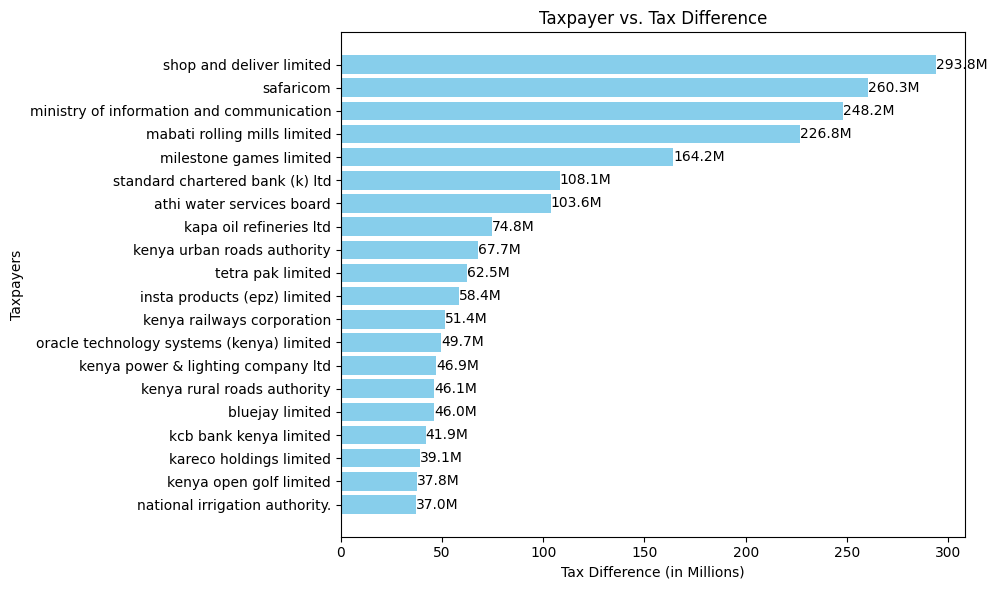

In [ ]:
plot_gvd(gainers.head(20))